In [1]:
import os
os.chdir('/Users/ngdnh/Codespace/PulsatingPulseShop/')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%config InlineBackend.figure_formats = ['svg']

In [2]:
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService
import utility as ut
import qutip as qt 
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import json
import datetime
from qiskit_ibm_runtime import SamplerV2 as Sampler
from scipy.stats import norm
from scipy.stats import gaussian_kde

In [3]:
plt.rcParams['axes.linewidth'] = 1.0
%config InlineBackend.figure_formats = ['svg']
today = datetime.datetime.now()

print(today)

2025-02-08 17:04:10.073224


# DRAG combined with APE

We use APE to optimize the DRAG coefficient to combat phase error. The qubit of interest is qubit 109 of the 127-qubit processor `ibm_brisbane`.

In [4]:
service = QiskitRuntimeService()
print(service.backends())
backend = service.backend('ibm_brisbane')

qubit = 109
clbit = 0

num_qubits = int(qubit+1)
num_clbits = 1

weight = 1

rough_01_freq = backend.defaults().qubit_freq_est[qubit]
qubit_anharmonicty = backend.properties().qubits[qubit][3].value * 1e9
rough_12_freq = rough_01_freq + qubit_anharmonicty

print('Chosen backend', backend)
print(r"f01 = "+f'{round(rough_01_freq/1e9, 4)}'+' GHz')
print(r'f12 = '+f'{round(rough_12_freq/1e9, 4)}'+' GHz')
print(r'anharmonicity = '+f'{round(qubit_anharmonicty/1e9, 4)}'+' GHz')

[<IBMBackend('ibm_fez')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_marrakesh')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_strasbourg')>, <IBMBackend('ibm_torino')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_brussels')>]
Chosen backend <IBMBackend('ibm_brisbane')>
f01 = 4.985 GHz
f12 = 4.6779 GHz
anharmonicity = -0.3071 GHz


We call out the `sx12_params` for $\pi/2$ pulses

In [16]:
with open("./sx12_params.json", "r") as json_file:
    sx12_params = json.load(json_file)

sx12_params

{'freq': 4677857270.602841, 'dur': 40, 'amp': 0.23678929765886286, 'beta': 0}

In [17]:
sx12_params['amp'] = 0.23525

In [18]:
with open("./x12_params.json", "r") as json_file:
    x12_params = json.load(json_file)

x12_params

{'freq': 4677857270.602841, 'dur': 40, 'amp': 0.4797979797979798, 'beta': 0}

As usual, we have a reset schedule

In [67]:
dur_reset = x12_params['dur']
amp_reset = x12_params['amp']
reset_gate = qiskit.circuit.Gate('reset', 1, [])

with qiskit.pulse.build(backend=backend) as reset_sched:
        drive_chan = qiskit.pulse.drive_channel(qubit)
        qiskit.pulse.set_frequency(rough_12_freq, drive_chan)
        qiskit.pulse.play(qiskit.pulse.Gaussian(duration=dur_reset, amp=amp_reset, sigma=int(dur_reset/4)), drive_chan)

reset_sched

ScheduleBlock(SetFrequency(4677857270.602841, DriveChannel(109)), Play(Gaussian(duration=40, sigma=10, amp=0.4797979797979798, angle=0.0), DriveChannel(109)), name="block5403", transform=AlignLeft())

In [178]:
with qiskit.pulse.build(backend=backend) as x12_sched:
        drive_chan = qiskit.pulse.drive_channel(qubit)
        qiskit.pulse.set_frequency(rough_12_freq, drive_chan)
        qiskit.pulse.play(qiskit.pulse.Gaussian(duration=x12_params['dur'], amp=x12_params['amp'], sigma=int(dur_reset/4)), drive_chan)

with qiskit.pulse.build(backend=backend) as mx12_sched:
        drive_chan = qiskit.pulse.drive_channel(qubit)
        qiskit.pulse.set_frequency(rough_12_freq, drive_chan)
        qiskit.pulse.play(qiskit.pulse.Gaussian(duration=x12_params['dur'], amp=-x12_params['amp'], sigma=int(dur_reset/4)), drive_chan)

x12_sched, mx12_sched

(ScheduleBlock(SetFrequency(4677857270.602841, DriveChannel(109)), Play(Gaussian(duration=40, sigma=10, amp=0.4797979797979798, angle=0.0), DriveChannel(109)), name="block8404", transform=AlignLeft()),
 ScheduleBlock(SetFrequency(4677857270.602841, DriveChannel(109)), Play(Gaussian(duration=40, sigma=10, amp=-0.4797979797979798, angle=0.0), DriveChannel(109)), name="block8405", transform=AlignLeft()))

We have some helper functions

In [20]:
def schedule_builder(params, name, frequency=rough_12_freq):
    """
        Build a schedule for pulse on 12
    """

    num_pulse = params['num_pulse']

    with qiskit.pulse.build(backend=backend) as schedule:
        drive_chan = qiskit.pulse.drive_channel(qubit)
        qiskit.pulse.set_frequency(frequency, drive_chan)
        for n in range(num_pulse):
            with qiskit.pulse.phase_offset(params['angle'][n], drive_chan):
                qiskit.pulse.play(qiskit.pulse.Drag(duration=params['dur'][n],
                                                    amp=params['amp'][n], 
                                                    sigma=int(params['dur'][n]/4), 
                                                    beta=params['beta'][n],
                                                    name=name), drive_chan)
    return schedule
    
def gate(name, weight):
    return qiskit.circuit.Gate(name, weight, [])

In [115]:
time_gate

520

## The experiment

We now initiate experiment parameters. 

In [189]:
dur = sx12_params['dur']
amp_sx12 = sx12_params['amp']
drape_shots = int(input('Number of shots:'))

rep_range = []
num_rep = int(input('Number of reps:'))
for i in range(num_rep):
    ele = int(input())
    rep_range.append(ele)

min_beta = float(input('Min DRAG correction:'))
max_beta = float(input('Max DRAG correction:'))
num_beta = int(input('Number of steps:'))
    
beta_swept = np.linspace(min_beta, max_beta, num_beta)

In [190]:
print(min_beta, max_beta, num_beta, rep_range)

-0.55 -0.2 100 [1]


Here's the circuit that implements the experiment

In [191]:
dt = backend.configuration().dt

dt

5e-10

In [192]:
ad_circ_list = []

delay_gate = qiskit.circuit.Gate("delay", 1, [])

for rep in rep_range:
    for beta in beta_swept:
        time_gate = 0
        x12_gate = gate('X12', 1)
        mx12_gate = gate('mX12', 1)
        sx12_gate = gate('SX12', 1)
        sx12_params_drape = {'num_pulse': 1, 'angle': [0], 'dur': [dur], 'amp': [amp_sx12], 'beta': [beta]}
        sx12_sched = schedule_builder(sx12_params_drape, r'$R^{12}(\pi/2)$')
        
        pseudo_gate = gate('Pseudo Identity', 1)
        pseudo_params = {'num_pulse': 2, 'angle': [0, 0], 'dur': [dur, dur], 'amp': [amp_sx12, -amp_sx12], 'beta': [beta, beta]}
        pseudo_sched = schedule_builder(pseudo_params, r'$I$')

        msx12_gate = gate('ASX12', 1)
        msx12_params = {'num_pulse': 1, 'angle': [np.pi/2], 'dur': [dur], 'amp': [-amp_sx12], 'beta': [beta]}
        msx12_sched = schedule_builder(msx12_params, r'$R_{\phi}^{12}(\pi/2)$')

        ad_circ = qiskit.circuit.QuantumCircuit(num_qubits, num_clbits)
        ad_circ.x(qubit)
        ad_circ.append(sx12_gate, [qubit])
        time_gate += 40
        for j in range(rep):
            ad_circ.append(pseudo_gate, [qubit])
            time_gate += 80
        ad_circ.append(x12_gate, [qubit])
        time_gate += 80
        print(time_gate)
        with qiskit.pulse.build(backend=backend) as delay_schedule:
            drive_chan = qiskit.pulse.drive_channel(qubit)
            qiskit.pulse.set_frequency(rough_12_freq, drive_chan)
            qiskit.pulse.delay(time_gate, drive_chan)
        ad_circ.append(delay_gate, [qubit])
        ad_circ.append(mx12_gate, [qubit])
        ad_circ.append(msx12_gate, [qubit])
        ad_circ.x(qubit)
        ad_circ.measure(qubit, clbit)
        ad_circ.append(reset_gate, [qubit])
        ad_circ.add_calibration(delay_gate, [qubit], delay_schedule)
        ad_circ.add_calibration(x12_gate, [qubit], x12_sched)
        ad_circ.add_calibration(mx12_gate, [qubit], mx12_sched)
        ad_circ.add_calibration(sx12_gate, [qubit], sx12_sched)
        ad_circ.add_calibration(pseudo_gate, [qubit], pseudo_sched)
        ad_circ.add_calibration(msx12_gate, [qubit], msx12_sched)
        ad_circ.add_calibration(reset_gate, [qubit], reset_sched)
        ad_circ_list.append(ad_circ)

200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200


### Backend and Sampler

In [193]:
sampler = Sampler(backend)
 
sampler.options.default_shots = drape_shots
sampler.options.execution.meas_type = "kerneled"
sampler.options.execution.rep_delay = 0.0005

In [194]:
ad_job_single = sampler.run(ad_circ_list)
print(ad_job_single.job_id())
rabi_job_id_string = f'{ad_job_single.job_id()}'

cyh7ab1nrmz0008t5cn0


In [195]:
print(ad_job_single.status())

QUEUED


### Saving kerneled data

In [196]:
ad_job_params = {'backend': backend, 'qubit': qubit,
                   'ad_job_id_string': ad_job_single.job_id(), 'datetime': datetime.datetime.now(), \
                   'duration': dur, 'amp_sx12': amp_sx12, 'rep_range': rep_range, 'num_points': len(ad_circ_list), 'num_shots': drape_shots, \
                   'beta_max': max_beta, 'beta_min': min_beta, 'num_betas': num_beta,
                   'delay_overlap': True, 
                   'mapping_01': True,  
                   'rep_delay': sampler.options.execution.rep_delay, 
                   'extended_delay': 0, 
                   'idling_circuits': False,  
                   'unconditional_reset12': True} 

path = "./calibrator/drape/data/"
folder_name = ad_job_params['ad_job_id_string']
full_path = os.path.join(path, folder_name)

os.mkdir(full_path)

with open(f"./{path}/{ad_job_params['ad_job_id_string']}/params.pkl", "wb") as f:
    pickle.dump(ad_job_params, f)

In [197]:
job_id_collect = 'cyh7ab1nrmz0008t5cn0'

drape_job_single = service.job(job_id_collect)
drape_job_single.status()
drape_experiment_single = ut.DataAnalysis(experiment=drape_job_single, average=False, shots=drape_shots, qubit=0)
drape_experiment_single.retrieve_data(average=False)

with open(f"./{path}/{job_id_collect}/iq_data.pkl", "wb") as f:
    pickle.dump(drape_experiment_single.IQ_data, f)

## Data processing

In [21]:
def in_zero(point: complex, rabi_discrim):
    d = ut.distance(rabi_discrim['cluster_0_mean'], point)
    if d < rabi_discrim['radius_fit']:
        return True
    else:
        return d

def in_two(point: complex, rabi_discrim):
    d = ut.distance(rabi_discrim['cluster_2_mean'], point)
    if d < rabi_discrim['radius_fit']:
        return True
    else:
        return d
    
def shortest_distance(IQpoint, central_clusters):
    d0 = np.sqrt((np.real(IQpoint)-central_clusters[0][0])**2+(np.imag(IQpoint)-central_clusters[0][1])**2)
    d1 = np.sqrt((np.real(IQpoint)-central_clusters[1][0])**2+(np.imag(IQpoint)-central_clusters[1][1])**2)
    d2 = np.sqrt((np.real(IQpoint)-central_clusters[2][0])**2+(np.imag(IQpoint)-central_clusters[2][1])**2)
    lab = {'0': d0, '1': d1, '2': d2}
    smallest_label = min(lab, key=lab.get)
    
    return smallest_label

def discriminate(iq_data_level1, discrim, central_clusters):
    
    normal_points = []
    abnormal_points = []
    pop = []

    for data_point in iq_data_level1:
        abnormal_zero = []
        normal_zero = []
        normal_one = []
        abnormal_two = []
        normal_two = []
        for shot in data_point:
            if (in_two(shot, discrim) == True):
                normal_two.append(shot)
                continue
            elif (in_zero(shot, discrim) == True):
                normal_zero.append(shot)
                continue
            else:
                label = shortest_distance(shot, central_clusters)
                if label == '0':
                    abnormal_zero.append(shot)
                    continue 
                if label == '2':
                    abnormal_two.append(shot)
                    continue 
                else:
                    normal_one.append(shot)
        
        pop0 = (len(normal_zero)+len(abnormal_zero))/iq_data_level1.shape[1]
        pop1 = len(normal_one)/iq_data_level1.shape[1]
        pop2 = (len(normal_two)+len(abnormal_two))/iq_data_level1.shape[1]

        if np.abs(pop0+pop1+pop2 - 1.0) > 1e-6:
            print('Houston we have a problem!')
            print(pop0+pop1+pop2)
            
        pop_shot = [pop0, pop1, pop2]
        normal_points.append([normal_zero, normal_one, normal_two])
        abnormal_points.append([abnormal_zero, abnormal_two])
        pop.append(pop_shot)

    pop = np.array(pop)

    return normal_points, abnormal_points, pop

In [230]:
experiment_id = 'cyf2m287v8tg008hdsx0'
path = f"./calibrator/drape/data/{experiment_id}"

ad_iq_data = np.array(np.load(f"{path}/iq_data.pkl", allow_pickle=True))
ad_params = np.load(f"{path}/params.pkl", allow_pickle=True)

ad_params

{'backend': <IBMBackend('ibm_brisbane')>,
 'qubit': 109,
 'ad_job_id_string': 'cyf2m287v8tg008hdsx0',
 'datetime': datetime.datetime(2025, 2, 1, 15, 7, 14, 14073),
 'duration': 40,
 'amp_sx12': 0.23525,
 'rep_range': [1, 3, 5],
 'num_points': 300,
 'num_shots': 5000,
 'beta_max': -0.2,
 'beta_min': -0.55,
 'num_betas': 100,
 'delay_overlap': True,
 'mapping_01': True,
 'rep_delay': 0.0005,
 'extended_delay': 0,
 'idling_circuits': False,
 'unconditional_reset12': True}

In [231]:
rabi_discrim = np.load('./rabi_discrim.pkl', allow_pickle=True)

rabi_discrim

{'cluster_0_mean': np.complex64(-34.688778+33.247574j),
 'cluster_2_mean': np.complex64(22.613844+8.244572j),
 'radius_fit': 31.259960326732763}

In [232]:
central_clusters = np.load('./central_clusters.npy', allow_pickle=True)

central_clusters

array([[-35,  30],
       [ 32,  32],
       [ 22,   6]])

In [233]:
normal_points, abnormal_points, drape_pop = discriminate(ad_iq_data, rabi_discrim, central_clusters)
drape_pop_135 = np.reshape(drape_pop, (len(ad_params['rep_range']), ad_params['num_betas'], 3))
beta_swept = np.linspace(ad_params['beta_min'], ad_params['beta_max'], ad_params['num_betas'])
drape_pops = [drape_pop_135[0][:, 2], drape_pop_135[1][:, 2], drape_pop_135[2][:, 2]]
y_fit_pops = []
popt_pops = []

for pop in drape_pops:
    popt, yfit, pcov = ut.fit_function(beta_swept, 
                                    pop, 
                                    lambda x, A, B: (A*x+B), 
                                    [-0.5, 0])
    y_fit_pops.append(yfit)
    popt_pops.append(popt)

IndexError: list index out of range

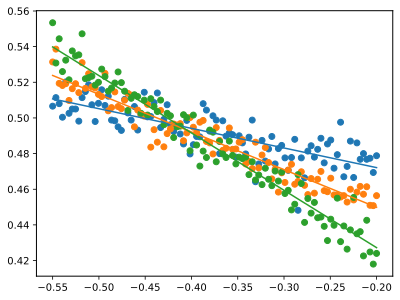

In [234]:
for i in range(4): 
    plt.scatter(beta_swept, drape_pops[i])
    plt.plot(beta_swept, y_fit_pops[i], label=f'{i}')

# plt.axhline(0.5)
# plt.axvline(-0.45)
plt.legend()